# Comparison plots
This notebook aims to reproduce most of the plots in the discussion section of [Lochner et al. 2022](https://arxiv.org/abs/2104.05676), making use of the metrics bundle in the csv file produced by the OpSim team. 

**Installation**

The packages required are standard with the exception of `george`, a Gaussian process package, which can be installed with `pip install george`. This is only used for one plot though and could be ignored if you don't want the median internight gap per band plot. I also like to use the `widget` backend for matplotlib which allows more interactive plots. This can be installed with `pip install ipympl`. The line `%matplotlib widget` can simply be commented out if you don't want to use this package.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plot_tools
from scipy.interpolate import griddata
import george
from scipy.optimize import minimize

%matplotlib widget

In [2]:
# This just defines the colours and markers to use for the metrics in the plots
metric_colors = {'fom':'C0',
            'lss':'C1',
            'wl':'C2',
            'sn':'C3',
            'sl':'C4',
            'snz':'C5',
            'kn':'C6',
            'pz':'C9'
        }

metric_markers = {'fom':'o',
        'lss':'^',
        'wl':'s',
        'sn':'*',
        'snz':'P',
        'sl':'D',
        'kn':'X',
        'pz':'+'
    }

## Select metrics to plot
We start by selecting which metrics we want to plot and provide shorter display names. In order to convert the metrics correctly for comparison, we need to know if any transforms need to be applied (see Lochner et al. 2022 for futher details). Possibilities include: <br>

invert = $1/x$ <br>
convert_to_flux = $10^{(-x/2.5)}$ <br>
convert_to_precision = $1/x^2$ <br>
one_minus = $1-2x$

In [3]:
# This spreadsheet contains the correct conversions for each metric and standard names for them
metric_names = pd.read_csv('OS_metric_translations.csv', index_col=0)
metric_names.columns

Index(['desc_metric_name', 'desc_metric_display_name', 'maf_metric_v1_5_name',
       'maf_metric_v2_0_name', 'transform_invert', 'transform_mag_to_flux',
       'transform_to_precision', 'transform_one_minus', 'validated',
       'comment'],
      dtype='object')

## Metric files
When new simulations are run using the Feature Based Scheduler, a huge bundle of metrics are also run on those simulations and made available to the community. Try to stick to the latest file, starting with `summary_` available at: https://github.com/lsst-pst/survey_strategy/tree/main/fbs_2.0.

A summary of the v2.0 simulations is here: https://github.com/lsst-pst/survey_strategy/blob/main/fbs_2.0/SummaryInfo_v2.1.ipynb

This can also be updated for future versions of simulations.

While most of DESC's contributed metrics are available in this summary file, as of 3 October 2022 only a low-resolution approximation is available for the supernova (SN) metrics and we currently run those separately.

In [7]:
# Where the local copy of the summary file is
analysis_dir = 'FBS_analysis/' 

In [9]:
maf_output_summary_file = analysis_dir + 'summary_2023_01_01.csv'
maf_output_full_v2 = pd.read_csv(maf_output_summary_file, index_col=0)

In [10]:
maf_columns = []
for idx in metric_names.index:
    maf_columns.append(metric_names.loc[idx, 'maf_metric_v2_0_name'])

In [11]:
maf_output = maf_output_full_v2[maf_columns]

In [12]:
maf_output = maf_output.dropna() # Some simulations are missing metrics, mostly the SN and SL metrics

In [13]:
baseline = 'baseline_v2.0_10yrs'

### Replace the approxmiate MAF SN metric with the DESC one run externally

In [15]:
sn_metrics_v2 = pd.read_csv(analysis_dir + 'SN_metric_v2.0_2022_07_27.csv', index_col=0)
sn_metrics_v2_1 = pd.read_csv(analysis_dir + 'SN_metric_v2.1_2022_07_27.csv', index_col=0)
sn_metrics = pd.concat((sn_metrics_v2, sn_metrics_v2_1))

There's a mismatch between the sims in the MAF summary file and the DESC SN metrics, so we have to restrict the indices

In [16]:
sn_indices = sn_metrics.index
maf_indices = maf_output.index
print(len(sn_indices), len(maf_indices))
intersection = list(set(sn_indices) & set(maf_indices))
print(len(intersection))

261 380
161


In [17]:
maf_output = maf_output.loc[intersection]

In [18]:
sn_metric_name = metric_names.loc['sn', 'maf_metric_v2_0_name']
maf_output.loc[intersection, sn_metric_name] = sn_metrics.loc[intersection, 'nsn']

## Compute the metrics relative to baseline
We always compare metrics by subtracting their value at baseline, and then dividing by their value at baseline. So all metrics can be considered as percentage improvement or degradation.

In [19]:
def compute_relative_improvement(metric_series, 
                                 baseline, 
                                 invert=False,
                                 convert_to_flux=False,
                                 convert_to_precision=False,
                                 one_minus=False):
    """
    Calculates the improvement of the metric over the given baseline, including applying the appropriate 
    transforms. Transforms are applied in the same order as used in Lochner et al. so for instance, a value
    will first be converted to flux and then to precision.
    """
    if convert_to_flux:
        metric_series = 10**(-metric_series/2.5)

    if one_minus:
        metric_series = 1 - 2*metric_series

    if invert:
        metric_series = 1/metric_series

    if convert_to_precision:
        metric_series = 1/metric_series**2
        
    baseline_value = metric_series.loc[baseline]
    
    return (metric_series - baseline_value)/baseline_value   

In [20]:
maf_output_rel = maf_output.copy()
for idx in metric_names.index:
    metric = metric_names.loc[idx, 'maf_metric_v2_0_name']
    rel_series = compute_relative_improvement(maf_output[metric], 
                                 baseline,
                                 metric_names.loc[idx, 'transform_invert'], 
                                 metric_names.loc[idx, 'transform_mag_to_flux'],
                                 metric_names.loc[idx, 'transform_to_precision'],
                                 metric_names.loc[idx, 'transform_one_minus'])
    maf_output_rel[metric] = rel_series

At this point, we have 3 important dataframes: <br>
- `metric_names`: contains a key for each metric, its nice display name and the long name in the MAF file
- `maf_output`: the original MAF summary file for all the metrics we care about (i.e. their raw values for each sim)
- `maf_output_rel`: the relative improvement for each metric over baseline, after each metric has been transformed appropriately

## Plotting functions
The functions we will use to make all the plots

### Comparison plot function
Plot many metrics as a function of a specific attribute.

In [21]:
def comparison_plot(metrics_original, metrics_rel, metric_names, x_axis, 
                    probes=[], themes={}, 
                    ylabel='', xlabel='', save_plot=False, savefig_path='', 
                    smoothing='none', nbins=20,
                    plot_baseline=True, baseline_name='baseline_v2.0_10yrs', expand_ylim_by=[1.1, 1.1]):
    """
    Plots a set of metrics against a summary parameter from the simulations (e.g. area, depth, cadence etc.)
    
    Parameters
    ----------
    metrics_original : pd.DataFrame
        The original values for all metrics (columns) for each simulation (row).
    metrics_rel : pd.DataFrame
        The metrics appropriately transformed and expressed as relative improvement over baseline for all 
        metrics (columns) for each simulation (row).
    metric_names: pd.DataFrame
        A translation between what the metric was called in the Lochner et al. paper and its name in the MAF summary file.
    x_axis: string
        Which metric to use on the x-axis
    probes: list of strings
        Which probes to plot, uses the short hand in "metric_names" to translate them. A good base set is 
        ['fom', 'wl', 'sn', 'kn', 'sl']
    themes: dict, optional
        Allows some probes to be plotted with fainter and thinner lines. Provide a dictionary for probes with values of
        either 0 (normal, thick lines) or 1 (fainter, thin lines). Defaults to 0 for all probes.
    ylabel: string, optional
        Label for y axis
    xlabel: string, optional
        Label for x axis
    save_plot: bool, optional
        Whether or not to save the figure to file
    savefig_path: string, optional
        Filename and path for the figure if saving it
    smoothing: string, optional
        Whether to plot all points ('none') or simplify the plot by binning points ('binning'). Generally binning is a
        good idea as there can be hundreds of simulations.
    nbins: int, optional
        Number of bins to use if smoothing='binning'
    plot_baseline: bool, optional
        If true (default), will plot a line with some text indicating the x axis value at baseline
    baseline_name: string, optional
        Which simulation to take as baseline (note this should be the same one used in calculating the relative metric
        values)
    expand_ylim_by: list, optional
        Two values to allow expanding of the y axis to accommodate large legends. E.g. [1.1, 1.4] will expand the top y
        limit of the plot by 40% of the maximum value.
        
    """

    # sim_annotation_numbers = {
    #     'footprint_big_sky_dustv1.5_10yrs': 1,
    #     'footprint_newAv1.5_10yrs' : 2,
    # }
    
    
    
    t0 = {'lw':2, 'alpha':1}
    t1 = {'lw':1, 'alpha':0.8}

    themes_translations = {0:t0, 1:t1}
    
    if len(list(themes.keys())) == 0:
        for p in probes:
            themes[p] = 0

    x_axis_metric = metric_names.loc[x_axis, 'maf_metric_v2_0_name']
    xvals = metrics_original.loc[metrics_rel.index, x_axis_metric].astype('float')
    inds = np.argsort(xvals)

    plt.figure()
    

    ylim = [0,0]

    for i in range(len(probes)):
        metric = metric_names.loc[probes[i], 'maf_metric_v2_0_name']

        yvals = metrics_rel.loc[metrics_rel.index, metric].astype('float')

        x = xvals[inds].values
        y = yvals[inds].values

        unique_x = np.unique(x)
        unique_y = np.zeros(len(unique_x))

        for k in range(len(unique_x)):
            msk = x == unique_x[k]
            if sum(msk) == 1:
                unique_y[k] = y[msk]
            else:
                unique_y[k] = y[msk].mean()

        x = unique_x
        y = unique_y

        if smoothing == 'none':
            new_x = x
            new_y = y
            yerr = np.zeros(len(new_x))

        elif smoothing == 'binning':
            xgrid = np.linspace(x.min(), x.max(), nbins)
            x_delt = xgrid[1] - xgrid[0]
            new_x = []
            new_y = []
            yerr = []

            for k in range(len(xgrid)):
                msk = (x>=xgrid[k]) & (x<xgrid[k] + x_delt)
                if msk.sum() == 0:
                    pass
                elif msk.sum() == 1:
                    new_x.append(x[msk][0])
                    new_y.append(y[msk][0])
                    yerr.append(0)
                else:
                    new_x.append(x[msk].mean())
                    new_y.append(y[msk].mean())
                    yerr.append(y[msk].std())

            new_x = np.array(new_x)
            new_y = np.array(new_y)
            yerr = np.array(yerr)
            

        theme = themes_translations[themes[probes[i]]]
        plt.errorbar(new_x, new_y, yerr=yerr, marker=None,
                  lw=theme['lw'], alpha=theme['alpha'], 
                 color=metric_colors[probes[i]])
        plt.plot(new_x, new_y, marker=metric_markers[probes[i]],
                 label=metric_names.loc[probes[i], 'desc_metric_display_name'], lw=0,
                 linestyle=None, alpha=theme['alpha'], color=metric_colors[probes[i]])

        if (new_y+yerr).max() > ylim[1]:
            ylim[1] = (new_y+yerr).max()
        if (new_y-yerr).min() < ylim[0]:
            ylim[0] = (new_y-yerr).min()
        
###############################################################################################
        # Relic code to apply annotations to the plot. Left in just in case we need it again.
#     if len(annotations) != 0:
#         anno_x = []
#         anno_y = []
#         anno_sim = []
#         anno_num = []
#         for k in annotations.keys():
#             which_probe = annotations[k][0]
#             metric = probes_translations[which_probe]
#             yshift = -0.06 + annotations[k][1]
#             xtext = misc_metrics.loc[k, x_axis].astype('float')
#             ytext = metrics_rel.loc[k, metric].astype('float') + yshift
#             anno_x.append(xtext)
#             anno_y.append(ytext)
#             anno_sim.append(k)
#             anno_num.append(sim_annotation_numbers[k])

#         sorted_inds = np.argsort(anno_x)
#         counter = 1
#         print_str = 'Annotations: '
#         for ind in sorted_inds:
#             plt.text(anno_x[ind], anno_y[ind], (str)(counter), color='k')
#             # plt.text(anno_x[ind], anno_y[ind], (str)(anno_num[ind]), color='k')
#             sim_name = anno_sim[ind]
#             sim_name = sim_name.replace('_', '\_')
#             print_str += '%d-\\texttt{%s}, ' %(counter, sim_name)
#             # print_str += '%d-\\texttt{%s}, ' %(anno_num[ind], sim_name)
#             counter += 1
#         print(print_str[:-2]) 

    # handles, labels = plt.gca().get_legend_handles_labels()
    # # remove the errorbars
    # print(handles[0][0])
    # handles = [h[0] for h in handles]
    # print(handles[0])
 
    # plt.legend(handles, labels, numpoints=1, loc='best')
###############################################################################################
    plt.legend(loc='best')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

    ax = plt.gca()
    new_ylim = [ylim[0]*expand_ylim_by[0], ylim[1]*expand_ylim_by[1]]
    new_xlim = ax.get_xlim()
    
   
    zo = 0

    plt.plot(new_xlim, [0, 0], '--k', alpha=0.5, zorder=zo)

    if plot_baseline:

        base_val = float(metrics_original.loc[baseline_name, x_axis_metric])
        plt.plot([base_val, base_val], new_ylim, '--k', lw=1, alpha=0.3,
                 zorder=zo)
        plt.text(base_val, new_ylim[1]*0.8, 'baseline', 
                alpha=0.3, zorder=zo)


    plt.xlim(new_xlim)
    plt.ylim(new_ylim)
    plt.tight_layout()
    
    if len(savefig_path) != 0 and save_plot:
        plt.savefig(savefig_path)

### Individual sims plot function
Function to plot a set of simulations for some metrics

In [22]:
def plot_individual_sims(metrics_rel, metric_names, list_of_sims, probes=[], ylabel='', xlabel='',
                         save_plot=False, savefig_path='', expand_ylim_by=[1.1, 1.1],
                         legend_outside=False, figsize=(8,4)):
    """
    Plots the relative metrics for a subset of simulations.
    
    Parameters
    ----------
    metrics_rel : pd.DataFrame
        The metrics appropriately transformed and expressed as relative improvement over baseline for all 
        metrics (columns) for each simulation (row).
    metric_names: pd.DataFrame
        A translation between what the metric was called in the Lochner et al. paper and its name in the MAF summary file.
    list_of_sims: list of strings
        Which simulations to plot on the x axis. Note this should be a short list to maintain readability.
    probes: list of strings
        Which probes to plot, uses the short hand in "metric_names" to translate them. A good base set is 
         ['fom', 'wl', 'sn', 'kn', 'sl']
    ylabel: string, optional
        Label for y axis
    xlabel: string, optional
        Label for x axis
    save_plot: bool, optional
        Whether or not to save the figure to file
    savefig_path: string, optional
        Filename and path for the figure if saving it
    expand_ylim_by: list, optional
        Two values to allow expanding of the y axis to accommodate large legends. E.g. [1.1, 1.4] will expand the top y
        limit of the plot by 40% of the maximum value.
    legend_outside: bool, optional
        If true, will place the legend outside the plot area. The figure size may need to be adjusted.
    figsize: tuple, optional
        Matplotlib figsize
        
    """
                         
    plt.figure(figsize=figsize)
    x = np.arange(len(list_of_sims))
    xlim = [-0.1, len(x)-1+0.1]
    plt.plot(xlim, [0]*len(xlim), 'k--', alpha=0.5)
    
    for p in probes:
        metric = metric_names.loc[p, 'maf_metric_v2_0_name']
        y = metrics_rel.loc[list_of_sims, metric].astype('float')
        plt.plot(x, y, label=metric_names.loc[p, 'desc_metric_display_name'], 
                 color=metric_colors[p], marker=metric_markers[p])
        
    plt.xticks(x, list_of_sims, rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if legend_outside:
        plt.legend(bbox_to_anchor=(1.1, 1.00))
    else:
        plt.legend()
    
    ax = plt.gca()
    ylim = ax.get_ylim()
    new_ylim = [ylim[0]*expand_ylim_by[0], ylim[1]*expand_ylim_by[1]]
    plt.ylim(new_ylim)
    plt.xlim(xlim)
    plt.tight_layout()

    if len(savefig_path) != 0 and save_plot:
        plt.savefig(savefig_path)

### Convenience function to get a metric's full name
It's a bit long-winded to get the actual MAF name of the metric corresponding to, for instance, area. This little function makes it a bit easier.

In [23]:
def get_full_metric_name(metric, metric_names_df):
    """
    Convenience function to return the full MAF metric name corresponding to a shorthand like 'area' or 'depth'.
    
    Parameters
    ----------
    metric: str
        The shorthand for the metric. Must correspond to an item in the index of metric_names_df.
    metric_names_df: pd.DataFrame
        The dataframe containing details about the metric names (generally referred to as `metric_names` in this notebook).
    """
    return metric_names_df.loc[metric, 'maf_metric_v2_0_name']

In [24]:
# Standard set of probes to plot metrics for
probes_to_plot = ['fom', 'wl', 'sl', 'sn', 'kn']
y_label = '(metric - baseline)/baseline'

## Metric comparison plots
These are the plots used to draw general insights about observing strategy in Lochner et al. (2022). The plot the various metrics as a function of properties of the survey such as effective area and depth. There are also plots analysing specific families of simulations to better understand qualitative effects such as the impact of changing the filter distributions.

### Area

Reproduces Fig. 8 of Lochner et al. (2022).

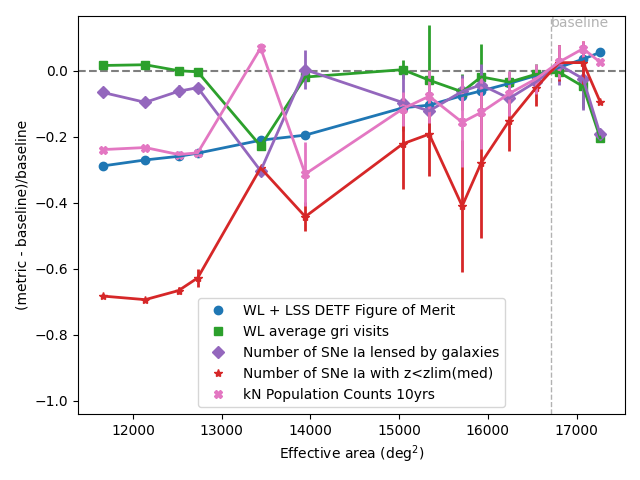

In [25]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'area', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='Effective area (deg$^2$)', ylabel=y_label)

**Curious about which simulations have so much area but poor performance?** 

Here's how you can access the raw numbers to check which simulations drive this behaviour. Remember though, the points on the plots are averaged and don't refer to specific simulations, although it's usually a family of simulations driving the behaviour.

In [26]:
x_axis_metric = get_full_metric_name('area', metric_names)
maf_output.loc[maf_output_rel.index, x_axis_metric].sort_values()

run
presto_gap2.0_v2.0_10yrs    11658.628026
presto_gap1.5_v2.0_10yrs    12137.025403
presto_gap2.5_v2.0_10yrs    12485.332266
presto_gap3.5_v2.0_10yrs    12541.564940
presto_gap3.0_v2.0_10yrs    12722.013074
                                ...     
shave_30_v2.1_10yrs         17008.285720
shave_32_v2.1_10yrs         17111.518839
shave_35_v2.1_10yrs         17180.340917
shave_38_v2.1_10yrs         17224.823481
shave_40_v2.1_10yrs         17265.948869
Name: Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer, Length: 161, dtype: float64

In this case it's the `shave` family of simulations that deliver the most effective area. These vary the exposure time from 20s to 40s and can impact the transient metrics and the WL systematics. 

### Median i-band depth in effective area

Reproduces Fig. 9 of Lochner et al. (2022).

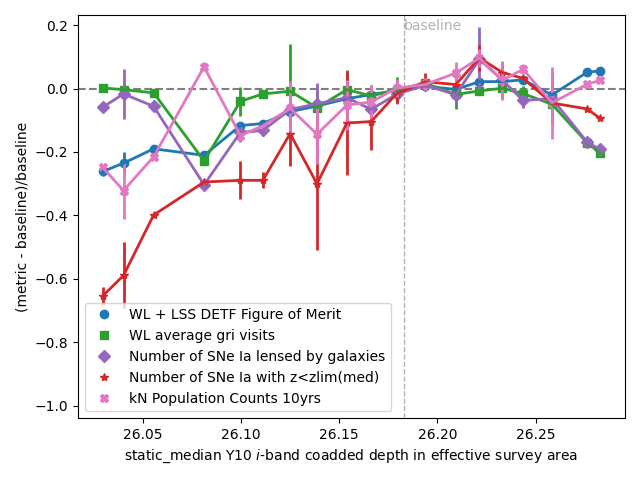

In [27]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'depth', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='static_median Y10 $i$-band coadded depth in effective survey area', 
               ylabel=y_label)

We can quickly see that it's the `presto` family largely causing poor depth and impacting most of the metrics. On the other end the `shave` family again causes most of the transient metrics and the weak lensing systematics metric to have poor performance.

In [28]:
x_axis_metric = get_full_metric_name('depth', metric_names)
maf_output.loc[maf_output_rel.index, x_axis_metric].sort_values()

run
presto_gap2.0_v2.0_10yrs          26.023217
presto_gap2.5_v2.0_10yrs          26.024171
presto_gap3.5_v2.0_10yrs          26.030520
presto_gap3.0_v2.0_10yrs          26.034161
presto_gap4.0_v2.0_10yrs          26.035858
                                    ...    
good_seeing_gsw20.0_v2.1_10yrs    26.244344
retro_baseline_v2.0_10yrs         26.255834
shave_35_v2.1_10yrs               26.260815
shave_38_v2.1_10yrs               26.276295
shave_40_v2.1_10yrs               26.282809
Name: Median ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer, Length: 161, dtype: float64

### Combined metric

Reproduces Fig. 10 of Lochner et al. (2022).

In [29]:
def calculate_combined_metric(metrics_rel):
    """
    Very simple approximation to combining the SN and FoM metrics from Lochner et al. 2022.
    
    Parameters
    ----------
    metrics_rel: pd.DataFrame
        Dataframe containing all the metrics relative to baseline.
    """
    frac_static = 0.5
    frac_sn = 0.5
    
    sn = metrics_rel[metric_names.loc['sn', 'maf_metric_v2_0_name']]
    fom = metrics_rel[metric_names.loc['fom', 'maf_metric_v2_0_name']]
    
    return frac_static*fom + frac_sn*sn

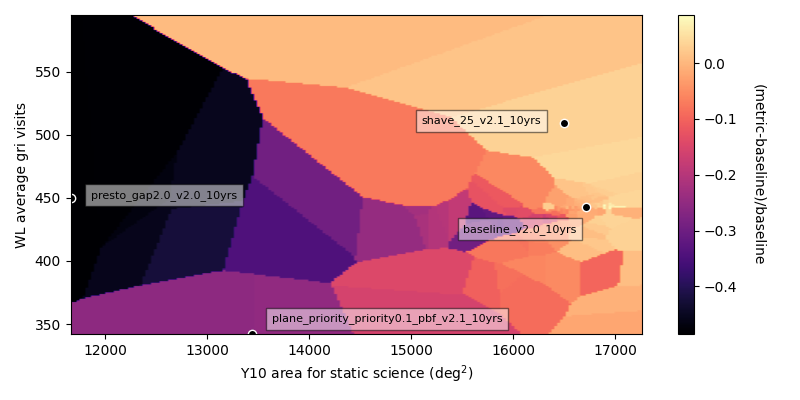

In [30]:
combined_metric = calculate_combined_metric(maf_output_rel)
maf_output_rel['combined'] = combined_metric

# We use the WL metric since it's the median number of visits.
xaxis = 'area'
yaxis = 'wl'

xaxis_metric = metric_names.loc[xaxis, 'maf_metric_v2_0_name']
yaxis_metric = metric_names.loc[yaxis, 'maf_metric_v2_0_name']
# maf_output.loc[maf_output_rel.index, metric_names.loc['depth', 'maf_metric_v2_0_name']]

X = np.array([maf_output.loc[maf_output_rel.index, xaxis_metric],
              maf_output.loc[maf_output_rel.index, yaxis_metric]
             ]).T
Z = np.array(maf_output_rel.combined)

xmin = X[:,0].min()
xmax = X[:,0].max()
ymin = X[:,1].min()
ymax = X[:,1].max()


extent = xmin, xmax, ymin, ymax

X[:,0] = (X[:,0] - xmin)/(xmax-xmin)
X[:,1] = (X[:,1] - ymin)/(ymax-ymin)

# These are some specific selected simulations to mark. You can choose different ones but note that getting the label
# positions right requires some fiddling (xshift and yshift below).
labels = [
         'presto_gap2.0_v2.0_10yrs',
         baseline,
         'shave_25_v2.1_10yrs',
         'plane_priority_priority0.1_pbf_v2.1_10yrs'
         ]

xlabs = []
ylabs = []


xshift = [200]*len(labels)
# xshift[0] = 100
xshift[1] = -1200
xshift[2] = -1400


yshift = [0]*len(labels)
yshift[1] = -20
yshift[3] = 10




for i in range(len(labels)):
    l = labels[i]
    xlab = maf_output.loc[l, xaxis_metric]
    ylab = maf_output.loc[l, yaxis_metric]

    xlabs.append(xlab)
    ylabs.append(ylab)

plt.close('all')
x = np.linspace(X[:,0].min(), X[:,0].max(), 200)
y = np.linspace(X[:,1].min(), X[:,1].max(), 200)
xgrid, ygrid = np.meshgrid(x, y)
zgrid = griddata(X, Z, (xgrid, ygrid), method='nearest')

plt.figure(figsize=(8,4))

for i in range(len(labels)):
    plt.plot(xlabs[i], ylabs[i], 'ok', markeredgecolor='w')
    ind = labels[i]+'.db'
    this_text = labels[i]
    plt.text(xlabs[i]+xshift[i], ylabs[i]+yshift[i], this_text, usetex=False, 
             fontsize=8,bbox=dict(facecolor='white', alpha=0.5))

im1=plt.imshow(zgrid, origin='lower', extent=extent, aspect='auto', cmap='magma')
plt.plot([])
cbar = plt.colorbar()
cbar.set_label('(metric-baseline)/baseline', rotation=-90, labelpad=20)

plt.xlabel(metric_names.loc[xaxis, 'desc_metric_display_name'])
plt.ylabel(metric_names.loc[yaxis, 'desc_metric_display_name'])
plt.tight_layout()

### Filter distribution

This plot (Fig. 11 of Lochner et al. 2022) just displays the effect of specific families of metrics that vary the filter distribution. Except for the KN metric that prefers a bluer distribution, changing the filter distribution has a largely negative effect on the DESC metrics.

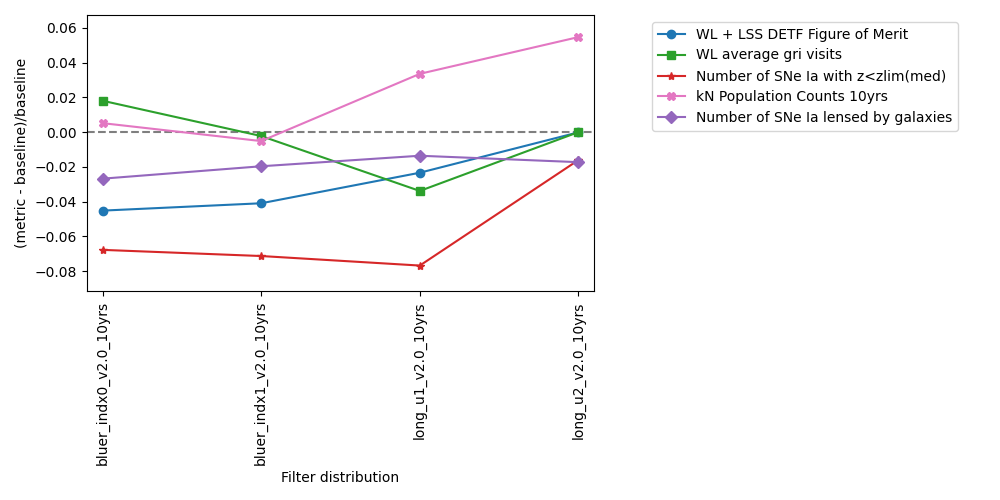

In [31]:
filter_change_sims = []
for idx in maf_output.index:
    if 'bluer' in idx or 'long_u' in idx:
        filter_change_sims.append(idx)
filter_change_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, filter_change_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Filter distribution', expand_ylim_by=[1.1, 1.1], figsize=(10,5), legend_outside=True)

### Visit pairs

These plots extend the idea of Fig. 12 of Lochner et al. (2022), investigating the effect of various simulation families that change the revisit strategy, all of which tend to be detrimental, especially to the SN metric.

#### Presto family

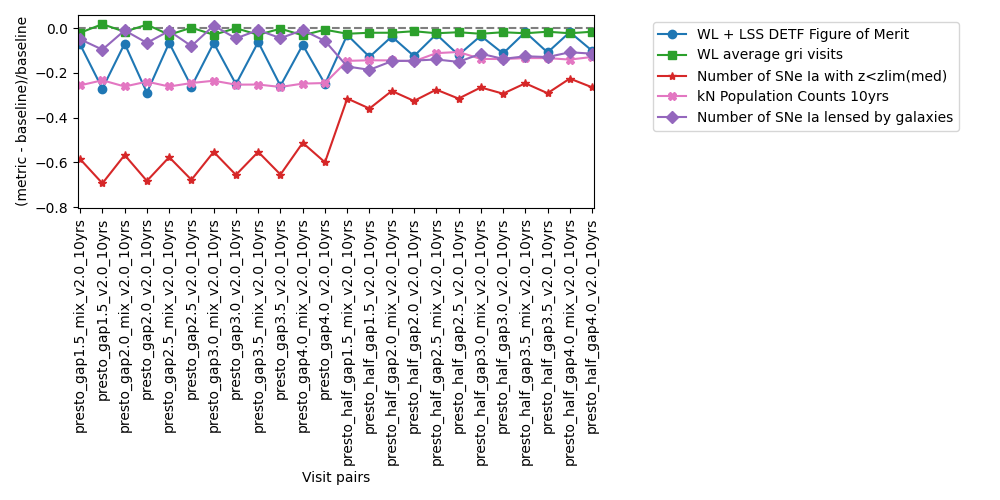

In [32]:
list_of_sims = []
for idx in maf_output.index:
    if 'presto' in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Visit pairs', expand_ylim_by=[1.1, 1.1], figsize=(10,5), legend_outside=True)

#### Long gap family

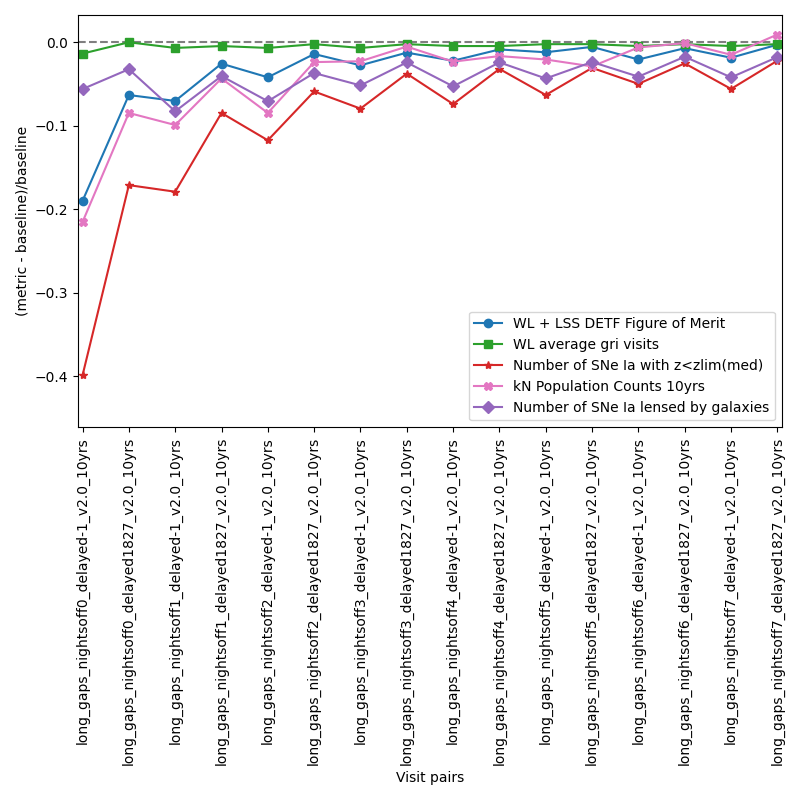

In [33]:
list_of_sims = []
for idx in maf_output.index:
    if 'long_gaps' in idx and 'np_' not in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Visit pairs', expand_ylim_by=[1.1, 1.1], figsize=(8,8), legend_outside=False)

#### Long gap family - NP

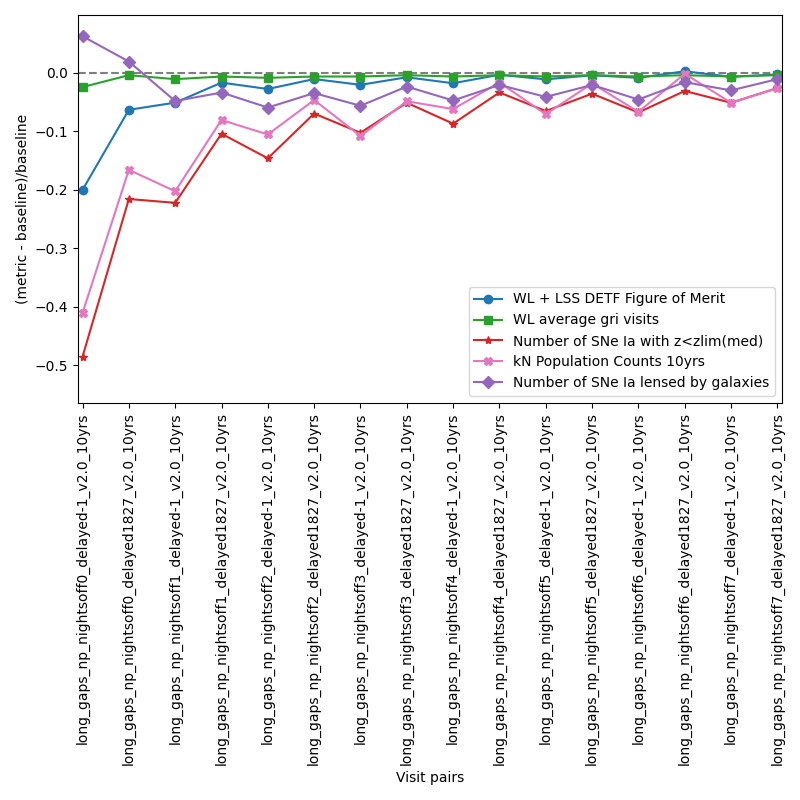

In [34]:
list_of_sims = []
for idx in maf_output.index:
    if 'long_gaps' in idx and 'np_' in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Visit pairs', expand_ylim_by=[1.1, 1.1], figsize=(8,8), legend_outside=False)

### Exposure time

This is a more nuanced study extending Fig. 13 of Lochner et al. (2022), investigating the `shave` family that varies the exposure time with interesting results. We generally see the transient metrics preferring short exposure times, presumably because it results in higher cadence, while the FoM reduces due to loss of depth. `vary_expt_v2.0_10yrs` tries to vary the exposure to maintain constant depth, which does seem to improve the depth (so the FoM goes up) but results in poor SN metric performance.

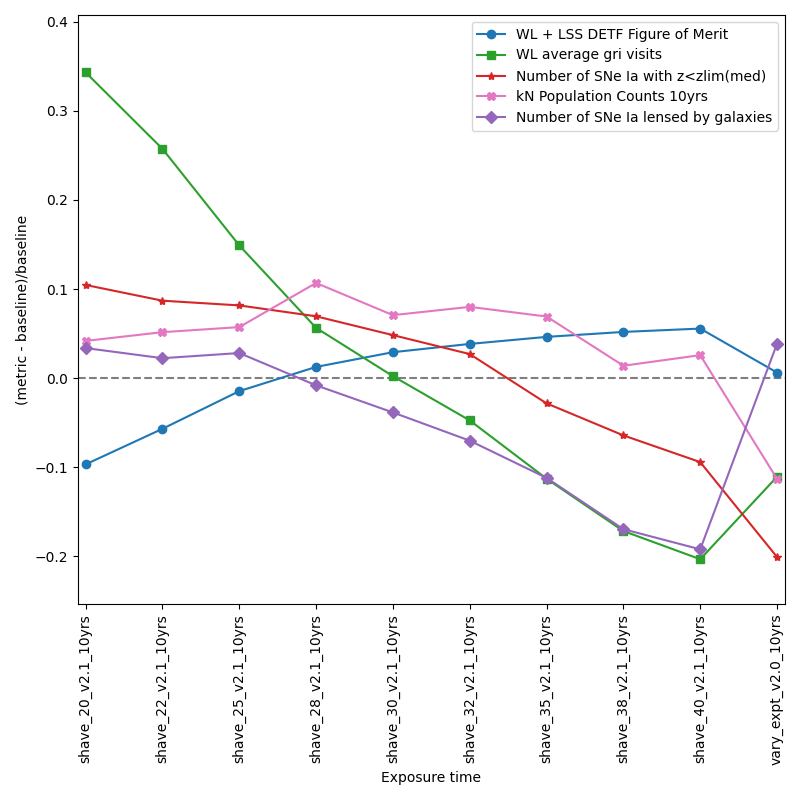

In [35]:
list_of_sims = []
for idx in maf_output.index:
    if 'shave' in idx or 'vary_exp' in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Exposure time', expand_ylim_by=[1.1, 1.1], figsize=(8,8), legend_outside=False)

### Median inter-night gap all bands

This plot attempts to reproduce Fig. 14 of Lochner et al. (2022) but has much stranger results. There are clearly much larger factors having an effect than just the cadence and it requires some digging into the families to figure out what's impacting the transient metrics so strangely.

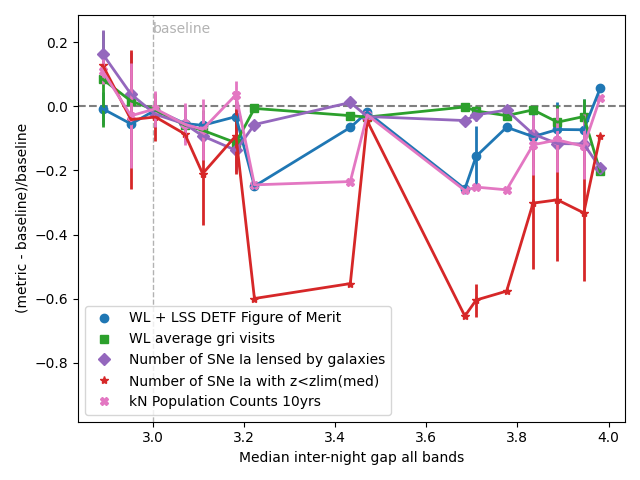

In [36]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'internight_gap', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='Median inter-night gap all bands', ylabel=y_label)

This shows that most of the poor performance of the SN metric around 3.2-3.4 internight gap is due to the `presto` family (although also the `plane_priority` has poor perfomance, which is expected). This shows that although the `presto` family actually has ok cadence on average, it likely results in long gaps in the light curves which results in poor SN performance. A similar analysis can be performed for other unusual areas of the plot.

In [37]:
x_axis_metric = get_full_metric_name('internight_gap', metric_names)
gap_only = maf_output.loc[maf_output_rel.index, x_axis_metric].sort_values()
inds = gap_only[(3.1<gap_only)&(gap_only<3.5)].index
maf_output_rel.loc[inds]

,3x2ptFoM ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,Median WeakLensingNvisits gri band non-DD HealpixSlicer,Total detected SNNSNMetric_nSN HealpixSlicer,Total detected SNSLMetric HealpixSlicer,Total detected KNePopMetric_all__multi_color_detect all models UserPointsSlicer,Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,Median ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,Median Median Inter-Night Gap WFD all bands HealpixSubsetSlicer,Median Median Inter-Night Gap WFD r band HealpixSubsetSlicer,Mean Median Season Length WFD all bands HealpixSubsetSlicer,fONv MedianNvis fO HealpixSlicer,combined
run,,,,,,,,,,,,
long_gaps_nightsoff1_delayed-1_v2.0_10yrs,-0.070229,-0.006772,-0.178921,-0.082669,-0.099071,-0.051580,-0.102186,0.033607,0.007924,0.004073,0.0,-0.124575
presto_gap4.0_mix_v2.0_10yrs,-0.074732,-0.031603,-0.512270,-0.008450,-0.247678,-0.059013,-0.077924,0.034283,0.319928,-0.028050,0.0,-0.293501
plane_priority_priority0.2_pbf_v2.1_10yrs,-0.099535,-0.180587,-0.211266,-0.208572,0.003096,-0.081764,-0.088095,0.049933,0.003879,-0.052646,0.0,-0.155401
shave_32_v2.1_10yrs,0.038401,-0.047404,0.027014,-0.070160,0.079979,0.023957,0.114627,0.055949,0.005235,-0.020806,0.0,0.032708
plane_priority_priority0.2_pbt_v2.1_10yrs,-0.103260,-0.180587,-0.211100,-0.205076,-0.008256,-0.084827,-0.092792,0.065182,0.010823,-0.046029,0.0,-0.157180
presto_gap4.0_v2.0_10yrs,-0.249302,-0.006772,-0.599365,-0.057084,-0.245098,-0.237909,-0.237487,0.074110,-0.153904,-0.023935,0.0,-0.424334
presto_gap3.0_mix_v2.0_10yrs,-0.066070,-0.029345,-0.552867,0.011718,-0.234778,-0.052735,-0.063064,0.144217,0.339534,-0.013260,0.0,-0.309468
twilight_neo_nightpattern4v2.0_10yrs,-0.018892,-0.033860,-0.046030,-0.032114,-0.026832,-0.012506,-0.040328,0.156596,0.150252,-0.001966,0.0,-0.032461


In [38]:
gap_only[inds]

run
long_gaps_nightsoff1_delayed-1_v2.0_10yrs    3.101527
presto_gap4.0_mix_v2.0_10yrs                 3.103557
plane_priority_priority0.2_pbf_v2.1_10yrs    3.150517
shave_32_v2.1_10yrs                          3.168568
plane_priority_priority0.2_pbt_v2.1_10yrs    3.196273
presto_gap4.0_v2.0_10yrs                     3.223065
presto_gap3.0_mix_v2.0_10yrs                 3.433433
twilight_neo_nightpattern4v2.0_10yrs         3.470579
Name: Median Median Inter-Night Gap WFD all bands HealpixSubsetSlicer, dtype: float64

### Median inter-night gap per band

Reproduces Fig. 15 of Lochner et al. (2022).

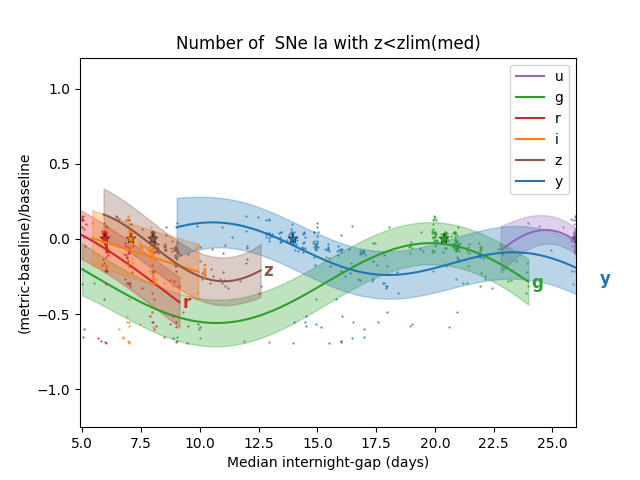

In [40]:
bands = ['u','g','r','i','z','y']
cols = ['C4', 'C2', 'C3', 'C1', 'C5', 'C0']
normalise_x = False
# which_metric = 'kn_Pop_kNe_counts'
which_metric = metric_names.loc['sn', 'maf_metric_v2_0_name']
# which_metric = 'static_median Y10 $i$-band coadded depth in effective survey area'
# which_metric = 'pz_y10_zlow_stdd'
# which_metric = 'sl_num_lensed_SNe_Ia_with_good_time_delays_lensed_by_galaxies'
# which_metric = 'fONv MedianNvis fO All visits HealpixSlicer'

        
# col = 'fONv MedianNvis fO All visits HealpixSlicer'
# inds = misc_metrics.loc[inds][(misc_metrics.loc[inds, col]<=1000)&(misc_metrics.loc[inds, col]>=900)].index

k = 0
plt.figure()
for b in bands:
    x_axis = metric_names.loc['internight_gap_filter', 'maf_metric_v2_0_name'].replace('r band', f'{b} band')
    
    x = maf_output_full_v2.loc[maf_output_rel.index, x_axis]
    if normalise_x:
        x = (x-x.min())/(x.max()-x.min())
    y = maf_output_rel[which_metric]

    kernel = george.kernels.ExpSquaredKernel((x.max()-x.min()))

    gp = george.GP(kernel, fit_mean=True, fit_white_noise=True)
    gp.compute(x, y.std())

    def neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.log_likelihood(y)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)

    result = minimize(neg_ln_like, gp.get_parameter_vector(),
                              jac=grad_neg_ln_like, method="L-BFGS-B",
                              tol = 1e-5)
    gp.set_parameter_vector(result.x)

    pred_x = np.linspace(x.min(), x.max(), 100)
    pred_y, y_var = gp.predict(y, pred_x, return_var=True)
    other_pred_y = gp.predict(y, x, return_cov=False)
    
    new_x = pred_x
    new_y = pred_y
    
    y_err = np.sqrt(y_var+(y-other_pred_y).std()**2)
    
    baseline_x = maf_output_full_v2.loc[baseline,x_axis]
    baseline_y = 0

    if not normalise_x:
        plt.fill_between(new_x, new_y-y_err, new_y+y_err, color=cols[k], alpha=0.3)
    plt.plot(new_x, new_y, color=cols[k], label=b)
    
    plt.plot(x, y, '.', markersize=1, color=cols[k]
        )
    plt.plot(baseline_x, baseline_y, '*', markersize=8, 
             markerfacecolor=cols[k], markeredgecolor='k', markeredgewidth=0.3)
    plt.text(new_x.max()+0.1, new_y[new_x.argmax()]-0.04, '$\mathbf{%s}$' %b, color=cols[k], fontsize=12)
    k+=1
plt.xlabel('Median internight-gap (days)')
plt.ylabel('(metric-baseline)/baseline')
plt.title('Number of  SNe Ia with z<zlim(med)')
plt.legend()
if not normalise_x:
    plt.xlim([4.9,26])


This is much more complex than was found in Lochner et al. (2022), demonstrating the effect of the revisit strategies being explored. It's very interesting that g-band now covers a much larger range of possible cadences than we saw previously.

### Cumulative season length

This is supposed to reproduce Fig. 16 of Lochner et al. (2022), but unfortunately we don't have the actual cumulative season length anymore. I have substituted with the mean season length, but this is not quite the same quantity and could be impacted by things like rolling cadence so it's likely this plot is not quite as useful as the previous version.

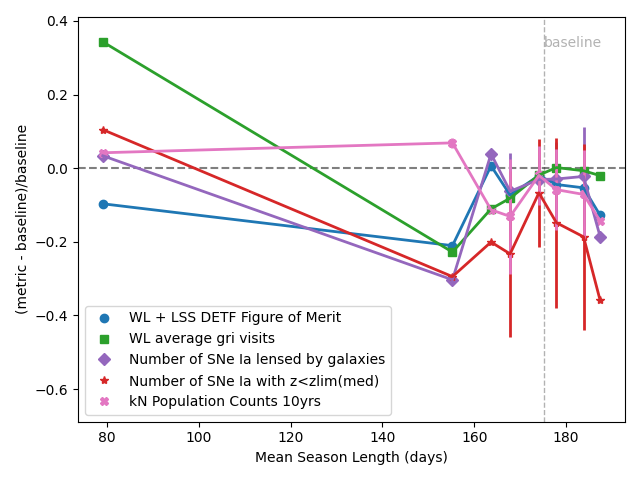

In [41]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'season_length', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='Mean Season Length (days)', ylabel=y_label)